<a href="https://colab.research.google.com/github/amanvishnani/CSCI-6505/blob/master/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Aman Vishnani <br/>
Banner #: B00840115

Assignment 1

In [0]:
import numpy as np
import math
from tqdm import tqdm

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
np.random.seed(10)

# **[8pts total] Q1. k-Nearest Neighbours Classifier on Synthetic Data**

## **a) [2pts] Create the data set.**

In [0]:
def create_dataset(p = 1):
  """Creates the data set.
    Args:
        p (int): The order of the norm.

    Returns:
        tuple: The train, validation, test and all data set.
    """
  x_range = np.arange(-15,16,1)
  x_range = x_range/10

  x1 = []
  x2 = []

  for i in x_range:
    for j in x_range:
      x1.append(i)
      x2.append(j)
  m = len(x1)
  x = np.stack([x1,x2]).T
  y = np.linalg.norm(x, p, 1)
  y = y.reshape(y.shape[0], 1)
  y[y<=1] = 1 
  y[y>1] = 2 

  all = np.hstack([x,y])
  np.random.shuffle(all)
  
  train = all[:math.floor(m*0.6), :]
  validation = all[math.floor(m*0.6)+1 : math.floor(m*0.8), :]
  test = all[math.floor(m*0.8)+1 :, :]
  train = { 'x' : train[:,:-1], 'y' : train[:,-1].reshape(-1,1) };
  validation = { 'x': validation[:,:-1], 'y': validation[:,-1].reshape(-1,1) }
  test = { 'x': test[:,:-1], 'y': test[:,-1].reshape(-1,1) }
  all_data = {'x': all[:,:-1], 'y': all[:,-1].reshape(-1,1) }
  
  return train, validation, test, all_data

In [0]:
train, val, test, all = create_dataset(2)

In [0]:
y = all['y']
x = all['x']

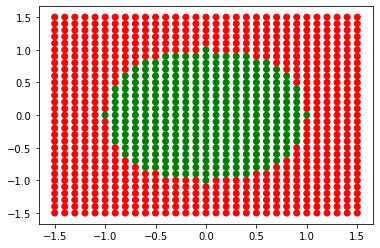

In [0]:
scatter_plot = np.empty_like(y, dtype='str')
scatter_plot[y==1] = 'g'
scatter_plot[y==2] = 'r'
scatter_plot = scatter_plot.ravel()
plt.scatter(x[:,0], x[:,1], c=scatter_plot)
plt.show()

## **b) [3pts] Implement the kNN algorithm.**

In [0]:
class KNN:

  def __init__(self):
    self.x_tests = []
    self.distances = []

  def fit(self, x, y, verbose=True, k=1, slice_sz=500):
    assert(x.shape[0] == y.shape[0])
    self.k = k
    self.x = x
    self.y = y.reshape(-1, 1)
    self.f = x.shape[1]
    self.slice_sz = slice_sz
    self.verbose = verbose
    return

  def calculate_distance(self, x):
    x = x.reshape(x.shape[0], -1)
    x_train_sq = np.sum(self.x**2, axis=1)
    x_test_sq = np.sum(x**2, axis=1)[:, np.newaxis]
    _2xy = - 2 * np.dot(x, self.x.T)
    distance =   x_train_sq + _2xy + x_test_sq
    return distance

  def predict(self, x):
    assert(x.shape[1] == self.x.shape[1])
    y_hats = []
    slices = self.get_slices(x, self.slice_sz)
    for slice1 in slices:
      distance = self.calculate_distance(slice1)
      sort_arg = np.argsort(distance, axis=1)
      top_k = sort_arg[:, :self.k]
      top_k_y = self.y[top_k]
      top_k_y = top_k_y.reshape(top_k_y.shape[0], top_k_y.shape[1])
      for xi in top_k_y:
        y_hat = self.mode(xi, self.k)
        y_hats.append(y_hat)
    return np.array(y_hats).reshape(x.shape[0], 1)
  
  def mode(self, x, k):
    unique, counts = np.unique(x, return_counts=True)
    count_dict = dict(zip(unique, counts))
    count_sorted = sorted(count_dict.items(), key=lambda x: x[1])
    if len(count_sorted) > 1 and count_sorted[-1][0] == count_sorted[-2][0]:
      # Tie Breaker
      return mode(x[:-1], k-1)
    else:
      return count_sorted[-1][0]
  
  def cost(self, y, y_hat):
    cost = np.invert(y == y_hat)
    err = cost.sum() / y.shape[0]
    return 1 - err

  def evaluate(self, x, y):
    y_hat = self.predict(x)
    return self.cost(y, y_hat)

  def get_slices(self, x, sz=500):
    n = x.shape[0]
    slice_count = math.ceil(n/sz)
    start = 0
    slices = []
    for i in range(0, slice_count):
      if(start>=n):
        break
      if(start + sz > n):
        slices.append(x[start:,:])
      else:
        slices.append(x[start: start + sz, :])
      start = start + sz
    return slices

In [0]:
model = KNN()
model.fit(x=x, y=y, k=4)
Accuracy = model.evaluate(x=x, y=y)
print("\nTrain Accuracy=", round(Accuracy*100,3), "%")


Train Accuracy= 98.959 %


In [0]:
Accuracy = model.evaluate(x=test['x'], y=test['y'])
print("\nTest Accuracy=", round(Accuracy*100,3), "%" )


Test Accuracy= 98.438 %


## **c) [1pt] Visualize the predictions.**

In [0]:
def create_countour_dataset(p=2):
  x_range = np.linspace(-1.5, 1.5, 310) 
  x_1, y_1 = np.meshgrid(x_range, x_range)
  x_1 = x_1.reshape(-1,1)
  y_1 = y_1.reshape(-1, 1)
  x_contour = np.hstack([x_1, y_1])
  y_contour = np.linalg.norm(x_contour, p, 1)
  y_contour = y_contour.reshape(-1,1)
  y_contour[y_contour<=1] = 1 
  y_contour[y_contour>1] = 2
  return x_contour, y_contour

In [0]:
def visualize_predctions(model, x=None, y=None, k=None):
  x_range = np.linspace(-1.5, 1.5, 310) 
  x_contour, y_contour = x, y
  y_hat_contour = model.predict(x_contour)
  y_hat_contour = y_hat_contour.reshape(310,310)
  plt.figure()
  plt.title("K="+ str(k))
  CS2 = plt.contour(x_range, x_range, y_contour.reshape(310, 310), colors=['red'])
  CS1 = plt.contour(x_range, x_range, y_hat_contour, colors=['green'])

**Queston: how the performance of the classifier depends on k?**


**Red Boundry is the expected value**

**Green Boundry is the actual value**

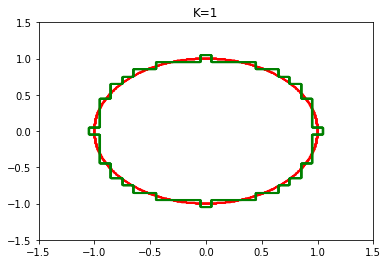

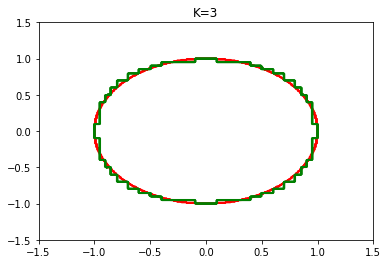

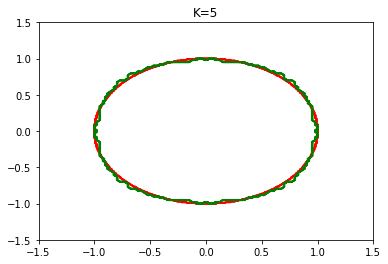

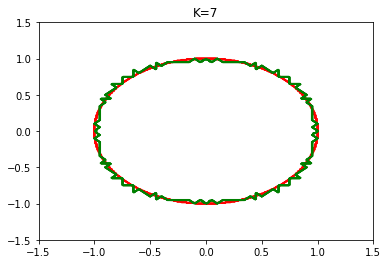

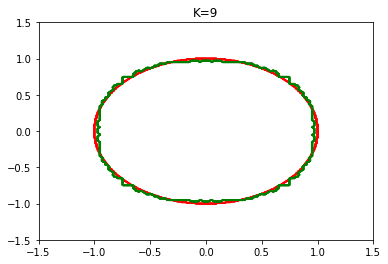

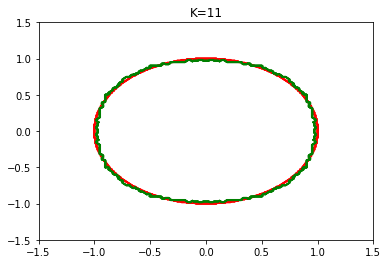

In [0]:
x_contour, y_contour = create_countour_dataset(p=2)
all_k = [1, 3, 5, 7, 9, 11]
model = KNN()
for index, k in enumerate(all_k):
  model.fit(x=x, y=y, k=k, slice_sz=15000)
  visualize_predctions(model, x_contour, y_contour, k)

## **d) [1pt] Try another data set. 1-Norm(X)**

In [0]:
train, val, test, all = create_dataset(p=1)
x_contour, y_contour = create_countour_dataset(p=1)

How does the performance of the classifier change with k?

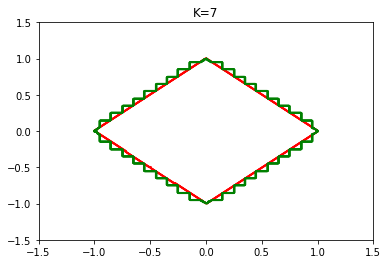

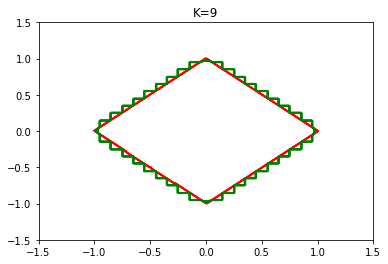

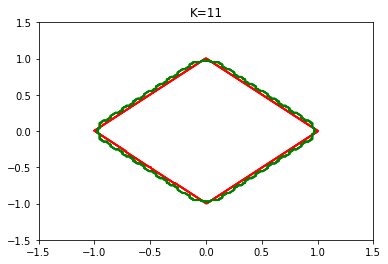

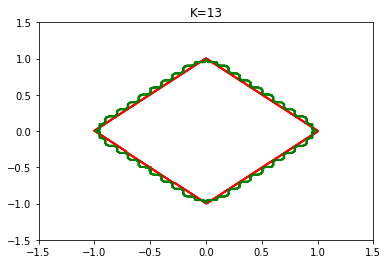

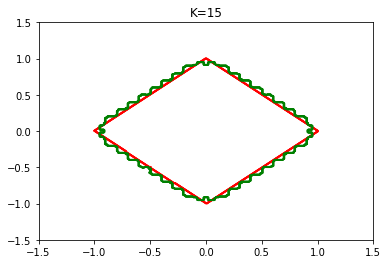

In [0]:
model = KNN()
for k in [7, 9, 11, 13, 15]:
  model.fit(x=all['x'], y=all['y'], k=k,slice_sz=15000)
  visualize_predctions(model, x_contour, y_contour, k)

 **Do you think using Euclidean distance for kNN is always the best choice?** <br/>
Euclidean distance can be optimized by expanding (X-Y)^2 to (X^2 -2XY + Y^2). However the model doesn't seem to perform well with p < 1 which can be visualized from the above plotted graph. It's hard to say from this study that the causality of the model performing poorly is totally dependent on distance function since we have not explored other function.

## **e) [1pt] Continue exploring data sets. 0.4-Norm(X)**

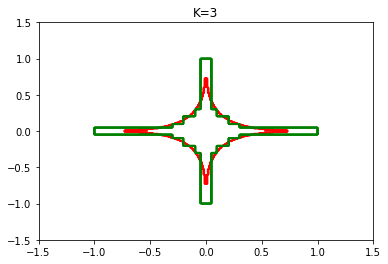

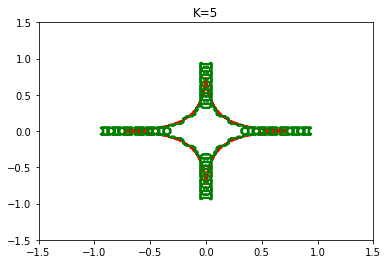

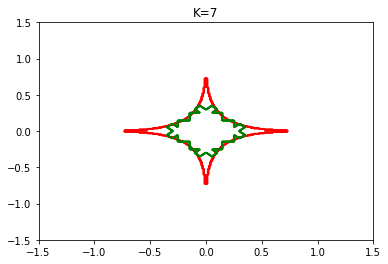

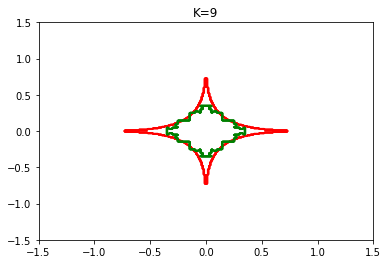

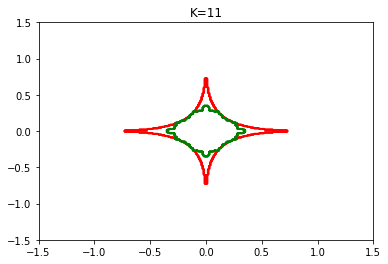

In [0]:
train, val, test, all = create_dataset(p=0.4)
x_contour, y_contour = create_countour_dataset(p=0.4)
model = KNN()
for k in [3,5, 7, 9, 11]:
  model.fit(x=all['x'], y=all['y'], k=k, slice_sz=15000)
  visualize_predctions(model, x_contour, y_contour, k)

# **[5pts] Q2. k-Nearest Neighbours Classifier on MNIST Data**

In [0]:
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
def get_mnist_dataset(batch_size = 2500, val_batch_size = 500, shuffle=True):
  (mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = mnist.load_data()
  mnist_test_x = mnist_test_x.reshape(-1, 784) / 255
  mnist_test_y = mnist_test_y.reshape(-1, 1)
  mnist_train_x = mnist_train_x.reshape(-1, 784) / 255
  mnist_train_y = mnist_train_y.reshape(-1, 1)
  mnist_train = np.append(mnist_train_x, mnist_train_y, axis=1)
  mnist_test = np.append(mnist_test_x, mnist_test_y, axis=1)
  if shuffle is True:
    np.random.shuffle(mnist_train)
    np.random.shuffle(mnist_test)
  mnist_train_set_x, mnist_train_set_y = mnist_train[:batch_size,:-1], mnist_train[:batch_size, -1].reshape(-1,1)
  mnist_val_set_x, mnist_val_set_y = mnist_train[batch_size: batch_size + val_batch_size,:-1], mnist_train[batch_size: batch_size + val_batch_size, -1].reshape(-1,1)
  return (mnist_train_set_x, mnist_train_set_y), (mnist_val_set_x, mnist_val_set_y)

In [0]:
(train_x, train_y), (test_x, test_y) = get_mnist_dataset(50000, 10000)

11493376/11490434 [==============================] - 0s 0us/step


[5.]


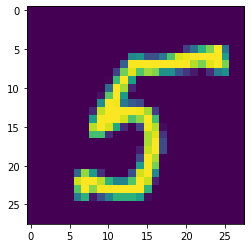

In [0]:
plt.imshow(train_x[0,:].reshape(28,28))
print(train_y[0])

## MNIST on Val Set (10000) and Train Set = 50000

In [0]:
model = KNN()
model.fit(x=train_x, y=train_y, k=k, slice_sz=500)
Accuracy = model.evaluate(x=test_x, y=test_y)

In [0]:
print("Accuracy=",round(Accuracy*100,2),"%")

Accuracy= 96.55 %


In [0]:
(train_x, train_y), (test_x, test_y) = get_mnist_dataset()

## **[2pts] Explore k values.**

In [0]:
def run_100_k(train_x, train_y, test_x, test_y):
  train_Accuracy = []
  validation_Accuracy = []
  model = KNN()
  Range = [x for x in range(3, 101, 5)]
  for k in tqdm(Range):
    model.fit(x=train_x, y=train_y, verbose=False, k=k, slice_sz=1000)
    Accuracy = model.evaluate(x=train_x, y=train_y)
    val_Accuracy = model.evaluate(x=test_x, y=test_y)
    train_Accuracy.append(Accuracy)
    validation_Accuracy.append(val_Accuracy)
  plt.plot(train_Accuracy, linestyle='-', color='g', label='Train Accuracy')
  plt.plot(validation_Accuracy, linestyle=':', color='b', label='Test Accuracy')
  plt.title("Train Vs Test Accuracy")
  plt.xlabel("K in KNN")
  plt.ylabel("Accuracy rate");
  plt.legend(loc='best')
  plt.xticks([x for x in range(len(Range))], [str(x) for x in Range])

100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


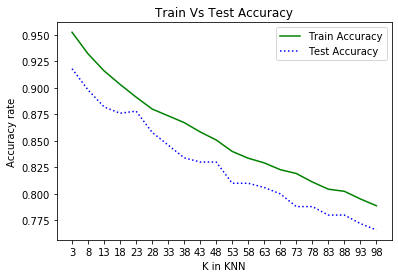

In [0]:
run_100_k(train_x, train_y, test_x, test_y)

In [0]:
model = KNN()
(train_x, train_y), (test_x, test_y) = get_mnist_dataset()
model.fit(x=train_x, y=train_y, k=3)
test_Accuracy = model.evaluate(x=test_x, y=test_y)
print(test_Accuracy)

0.928


In [0]:
print("\n Test Accuracy", round(test_Accuracy*100),"%")


 Test Accuracy 93.0 %


## **b) [1pt] Explore data set size.**

In [0]:
train_Accuracy = []
validation_Accuracy = []
size_labels = []
size_combination = [(100, 10), (500, 50), (1000, 100), (2000, 200),
                    (5000, 500), (10000, 1000), (20000, 2000)]
model = KNN()
for (train_sz, test_sz) in size_combination:
  print(train_sz, test_sz)
  (train_x, train_y), (test_x, test_y) = get_mnist_dataset(train_sz, test_sz)
  model.fit(x=train_x, y=train_y, verbose=False, k=13, slice_sz=2500)
  Accuracy = model.evaluate(x=train_x, y=train_y,)
  val_Accuracy = model.evaluate(x=test_x, y=test_y)
  train_Accuracy.append(Accuracy)
  validation_Accuracy.append(val_Accuracy)
  size_labels.append(str(train_sz))


100 10
500 50
1000 100
2000 200
5000 500
10000 1000
20000 2000


In [0]:
train_Accuracy

[0.7, 0.838, 0.885, 0.9005, 0.9286, 0.9496, 0.957]

In [0]:
validation_Accuracy

[0.5, 0.86, 0.81, 0.895, 0.928, 0.945, 0.9555]

([<matplotlib.axis.XTick at 0x7fe23eeb6f28>,
 <a list of 7 Text xticklabel objects>)

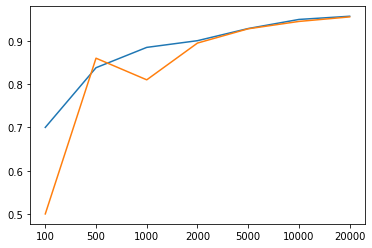

In [0]:
plt.plot(train_Accuracy)
plt.plot(validation_Accuracy)
plt.xticks(list(range(0, len(train_Accuracy))), size_labels)

## **c) [2pt] Explore image resolutions.**

In [0]:
def resize_images(data):
  """
  Resizes the images from (m, 28, 28) to (m, 22, 22)
  Where m is the number of training examples.
  Args:
      data (m, 28, 28): numpy ndarray of m images.
  Returns:
      resized_data (m, 22, 22):  numpy ndarray of m  resized images.
  """
  data = data.reshape(-1, 28, 28)
  idx = []
  for i in range(0, 28):
    # Remove every 5th element starting 0 
    if i%5 != 0:
      idx.append(i)
  data = data[:,idx]
  data = data[:,:, idx]
  return data


In [0]:
(train_x, train_y), (test_x, test_y) = get_mnist_dataset()
reduced_train_x = resize_images(train_x).reshape(-1, 22*22)
reduced_test_x = resize_images(test_x).reshape(-1, 22*22)

In [0]:
reduced_train_x.shape

(2500, 484)

100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


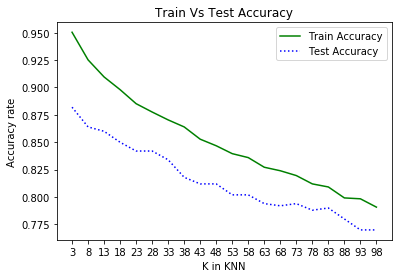

In [0]:
run_100_k(reduced_train_x, train_y, reduced_test_x, test_y)

**What happens if you repeat part (a) but reduce the resolution of
the data sets?** <br/>

The model performs poorly because of data loss in training set and test set because of resize

# **[4pts total] Q3. The Curse of Dimensionality**

## **[2pts] Computing expectation in 2D**

<a href="https://ibb.co/zGfc3V9"><img src="https://i.ibb.co/0hJN0y4/New-Doc-2020-01-25-12-24-15.jpg" alt="New-Doc-2020-01-25-12-24-15" border="0"></a>

In [0]:
from scipy.integrate import dblquad

In [0]:
f1 = lambda y, x: (x-y)**2

In [0]:
Ez = dblquad(f1, 0, 1, lambda x: 0, lambda x: 1)[0]

In [0]:
print("E[z]=", Ez)

E[z]= 0.16666666666666666


In [0]:
f2 = lambda y, x: (x-y)**4

In [0]:
Ez2 = dblquad(f2, 0, 1, lambda x: 0, lambda x: 1)[0]

In [0]:
Var_z = Ez2 - (Ez**2)

In [0]:
print("Var[z] = ", Var_z) 

Var[z] =  0.03888888888888889


## **[2pts] Computing expected distances in n-d**


<a href="https://ibb.co/2tQztmq"><img src="https://i.ibb.co/QNRWNz9/New-Doc-2020-01-25-12-24-15-2.jpg" alt="New-Doc-2020-01-25-12-24-15-2" border="0"></a><br />

In [0]:
# Change n accordingly
n = 20
Exp_R = n * Ez
print("E[R]=",Exp_R," where number of dim are", n)

E[R]= 3.333333333333333  where number of dim are 20


In [0]:
n = 4
Var_R = n * Ez - n * (Ez**2)
print("V[R]=",Var_R," where number of dim are", n)

V[R]= 0.5555555555555556  where number of dim are 4


# **[3pts] Q4. Decision Trees**

### **(a) Generate D1, D2 and Two other Data Sets (p = 0.4 and 7)**

In [0]:
def score(y_hat, y):
  y = y.reshape(-1, 1)
  y_hat = y_hat.reshape(-1, 1)
  cost = np.invert(y == y_hat)
  err = cost.sum() / y.shape[0]
  return 1 - err

In [0]:
D1 = create_dataset(p=1)

In [0]:
D2 = create_dataset(p=2)

In [0]:
D3 = create_dataset(p=0.4)

In [0]:
D4 = create_dataset(p=7)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 

In [0]:
train, val, test, all = D1
clf = DecisionTreeClassifier(random_state=10)
clf = clf.fit(train['x'], train['y'])
y_hat = clf.predict(val['x'])
score(y=val['y'], y_hat=y_hat)

0.9528795811518325

In [0]:
train, val, test, all = D2
clf = DecisionTreeClassifier(random_state=10)
clf = clf.fit(train['x'], train['y'])
y_hat = clf.predict(val['x'])
score(y=val['y'], y_hat=y_hat)

0.9738219895287958

In [0]:
train, val, test, all = D3
clf = DecisionTreeClassifier(random_state=10)
clf = clf.fit(train['x'], train['y'])
y_hat = clf.predict(val['x'])
score(y=val['y'], y_hat=y_hat)

0.9895287958115183

In [0]:
train, val, test, all = D4
clf = DecisionTreeClassifier(random_state=10)
clf = clf.fit(train['x'], train['y'])
y_hat = clf.predict(val['x'])
score(y=val['y'], y_hat=y_hat)

0.9895287958115183

## **(b) Split Training set in Training and Validation Set**

In [0]:
from keras.datasets import mnist
import numpy as np
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = mnist.load_data()
mnist_train = np.append(mnist_train_x.reshape(-1, 784), mnist_train_y.reshape(-1, 1), axis=1)
np.random.shuffle(mnist_train)
mnist_train_set_x, mnist_train_set_y = mnist_train[:50000,:-1], mnist_train[:50000, -1].reshape(-1,1)
mnist_val_set_x, mnist_val_set_y = mnist_train[50000:,:-1], mnist_train[50000:, -1].reshape(-1,1)


In [0]:
mnist_train_set_x.shape

(50000, 784)

In [0]:
mnist_val_set_x.shape

(10000, 784)

In [0]:
mnist_test_x = mnist_test_x.reshape(-1, 784)
max_depth_options = [8, 11, 13, 15, 16]
val_gini = []
val_entropy = []
test_gini = []
test_entropy = []
for option in max_depth_options:
  clf = DecisionTreeClassifier(random_state=10, max_depth=option, criterion='gini')
  clf = clf.fit(mnist_train_set_x, mnist_train_set_y)
  y_hat = clf.predict(mnist_val_set_x)
  accuracy = score(y=mnist_val_set_y, y_hat=y_hat)
  val_gini.append(accuracy)
  y_hat = clf.predict(mnist_test_x)
  accuracy = score(y=mnist_test_y, y_hat=y_hat)
  test_gini.append(accuracy)

for option in max_depth_options:
  clf = DecisionTreeClassifier(random_state=10, max_depth=option, criterion='entropy')
  clf = clf.fit(mnist_train_set_x, mnist_train_set_y)
  y_hat = clf.predict(mnist_val_set_x)
  accuracy = score(y=mnist_val_set_y, y_hat=y_hat)
  val_entropy.append(accuracy)
  y_hat = clf.predict(mnist_test_x)
  accuracy = score(y=mnist_test_y, y_hat=y_hat)
  test_entropy.append(accuracy)
  

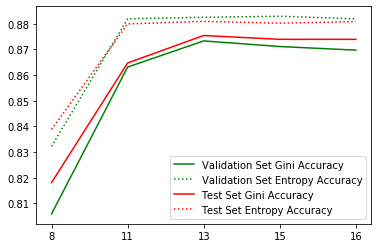

In [0]:
plt.plot(val_gini, linestyle='-', color='g', label='Validation Set Gini Accuracy')
plt.plot(val_entropy, linestyle=':', color='g', label='Validation Set Entropy Accuracy')
plt.plot(test_gini, linestyle='-', color='r', label='Test Set Gini Accuracy')
plt.plot(test_entropy, linestyle=':', color='r', label='Test Set Entropy Accuracy')
plt.xticks(list(range(0, len(val_entropy))), [ str(x) for x in max_depth_options ])
plt.legend(loc="best")

[Q] *What would be the meta-parameter settings that you would normally choose?*

1. From the above set graph we can observe that Entropy Critera seems to be working great for both validation and test set. Further more the accuracy for validation set in Entropy Critera is stable and not improving after max_depth=11. 

2. So I will choose Entropy Critera with max_depth=11.

3. I will not account Test results for choosing metaparameters.

# References </br>
[Distance Matrix Vectorization Trick (by Sourav Dey)](https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c)

[NumPy Docs](https://docs.scipy.org/doc/numpy/reference/)

[Matplotlib Countour](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contourf.html)

[Matplotlib Resources](https://matplotlib.org/contents.html)

[KNN Breaking the Tie](https://stats.stackexchange.com/questions/45580/dealing-with-ties-weights-and-voting-in-knn)